---
aliases:
- /2024/04/07/FlashAttention
date: '2024-04-07'
output-file: 2024-04-07-flashattention.html
title: Flash Attention - Fast and Memory Efficient Attention Mechanism

---

# FlashAttention - Fast and Memory Efficient Attention Mechanism

The attention layer is the main bottleneck in scaling longer sequences in LLM (Large Language Models), as its runtime and memory increase quadratically in the sequence length [ref. [FlashAttention-2](https://arxiv.org/abs/2307.08691)].


For each attention head, to reduce memory reads/writes, **FlashAttention** uses classical tiling techniques to load blocks of query, key, and value from GPU HBM (its main memory) to SRAM (its fast cache), compute attention with respect to that block, and write back the output to HBM. This reduction in memory reads/writes brings significant speedup (2-4x) in most cases. [ref. https://www.adept.ai/blog/flashier-attention]

The figure below is from [FlashAttention paper](https://arxiv.org/pdf/2205.14135) showing on the left that FlashAttention uses tiling to prevent materialization of the large 𝑁 × 𝑁 attention matrix (dotted box) on (relatively) slow GPU HBM. 

Here in the outer loop (red arrows), FlashAttention loops through blocks of the K and V matrices and loads them to fast on-chip SRAM. In each block, FlashAttention loops over blocks of Q matrix (blue arrows), loading them to SRAM, and writing the output of the attention computation back to HBM. 

On the right you see the speedup over the PyTorch implementation of attention on GPT-2. FlashAttention does not read and write the large 𝑁 × 𝑁 attention matrix to HBM, resulting in an 7.6× speedup on the attention computation according to the paper.

![image-20240507155528488](./images/image-20240507155528488.png)


This notebook has the objective to compared the benefits of the flash attention versus normal attentional mechanism using pytorch implementation of [scaled dot product attention](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) . 

This notebook is inspired by the following work:
- https://github.com/Dao-AILab/flash-attention
- https://github.com/thushv89/tutorials_deeplearninghero/blob/master/llms/flash_attention_torch.ipynb



## Pre-requisites

First let´s install the required package and versions.
This notebook was run using Amazon SageMaker Jupyter Lab,  image: SageMaker Distribution 1.7 and instance type: ml.g4dn.12xlarge.

ml.g4dn.12xlarge has 4 GPUs with nvidia t4 tensor core architecture containig each 64GB GPU memory.
Thus each GPU has a total of 16GB GPU memory.

In [ ]:
!pip install torch==2.0.1 transformers==4.30.2 nvidia-ml-py3 sentencepiece --quiet

In [1]:
import torch
from time import perf_counter
import pynvml
import pandas as pd

# Earliest version that has flash attention is 1.13
print(f"Torch version: {torch.__version__}")


Torch version: 2.0.1+cu117


## Let´s load some data

In [2]:
!wget https://www.gutenberg.org/files/98/98-0.txt; mv 98-0.txt book.txt

--2024-05-07 15:01:36--  https://www.gutenberg.org/files/98/98-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 807231 (788K) [text/plain]
Saving to: ‘98-0.txt’

98-0.txt            100%[===================>] 788.31K  --.-KB/s    in 0.1s    

2024-05-07 15:01:37 (7.14 MB/s) - ‘98-0.txt’ saved [807231/807231]



In [2]:
# Download some text from Project Gutenberg
# e.g. https://www.gutenberg.org/files/98/98-0.txt
with open("book.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(f"This text file has {len(text.split())} words")

This text file has 138965 words


## Simple Transformer and hyperparameters

In [3]:
n_heads = 32
d_model = 512
num_layers = 6
batch_size = 32

seq_length_range = [128, 256, 512, 1024]

# We are going to make the format [b, t, d] by default it's [t, b, d]
# Setting data type to float16
encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, device="cuda", batch_first=True, dtype=torch.float16)
transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


### Util functions to get GPU utilization

In [4]:
def get_gpu_utilization():
    """ Get the GPU utilization """
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return info.used//1024**2

def run_single_iteration(transformer_encoder, batch_size, seq_length, d_model):
    """ Run a single iteration through the model """
    input_data = torch.rand((batch_size, seq_length, d_model), device="cuda", dtype=torch.float16)
    mask = torch.nn.Transformer.generate_square_subsequent_mask(
        seq_length, device="cuda"
    ).half()

    with torch.inference_mode():
        t1 = perf_counter()
        out = transformer_encoder(input_data, mask=mask, is_causal=True)
        t2 = perf_counter()
        memory_in_gb = get_gpu_utilization()

    return {"time": t2-t1, "memory": memory_in_gb}

def generate_profile_dataframe(time_seq, mem_seq, x_range):
    return pd.DataFrame({"time": time_seq, "memory": mem_seq}, index=x_range)

## Attention Without Flash Attention

In [6]:
memory_consumption = []
time_taken = []

# Since version 1.13
with torch.backends.cuda.sdp_kernel(
        enable_flash=False, enable_math=True, enable_mem_efficient=True
):
    #warm up step
    res = run_single_iteration(transformer_encoder, batch_size, seq_length_range[0], d_model)

    print(f"Using Flash Attention: {torch.backends.cuda.flash_sdp_enabled()}")
    for t in seq_length_range:
        # Important to syncronize before each run
        # because cuda launch kernels asynchronously
        torch.cuda.synchronize()

        res = run_single_iteration(transformer_encoder, batch_size, t, d_model)
        time_taken.append(res["time"])
        memory_consumption.append(res["memory"])
        print(f"Sequence length: {t}")
        print(f"\tTime taken: {res['time']}s")
        print(f"\tGPU memory occupied: {res['memory']} MB")

profile_df = generate_profile_dataframe(time_taken, memory_consumption, seq_length_range)
profile_df.to_parquet("no_flash_profile.parquet")

Using Flash Attention: False
Sequence length: 128
	Time taken: 0.003820729000835854s
	GPU memory occupied: 758 MB
Sequence length: 256
	Time taken: 0.004297239000152331s
	GPU memory occupied: 1142 MB
Sequence length: 512
	Time taken: 0.004526317000454583s
	GPU memory occupied: 2678 MB
Sequence length: 1024
	Time taken: 0.004839346000153455s
	GPU memory occupied: 8822 MB


## Attention WITH Flash Attention

In [5]:
# IMPORTANT NOTES ON FLASH ATTENTION
# * Make sure you restart the runtime - to release GPU memory
# * FlashAttention currently supports:
#   * Turing, Ampere, Ada, or Hopper GPUs (e.g., H100, A100, RTX 3090, T4, RTX 2080).
#   * Supports fp16 and bf16 (bf16 requires Ampere, Ada, or Hopper GPUs).
#   * Head dimension needs to be multiples of 8, up to 128 (e.g., 8, 16, 24, ..., 128). Head dim > 64 backward requires A100 or H100.
flash_memory_consumption = []
flash_time_taken = []

# torch.backends.cuda.sdp_kernel() is deprecated.
# Please see, torch.nn.attention.sdpa_kernel() for the new context manager
# https://pytorch.org/tutorials/intermediate/scaled_dot_product_attention_tutorial.html
#with torch.backends.cuda.sdp_kernel(
#    enable_flash=True, enable_math=False, enable_mem_efficient=False
#):
#from torch.nn.attention import SDPBackend, sdpa_kernel
#with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):

    #warm up step
    res = run_single_iteration(transformer_encoder, batch_size, seq_length_range[0], d_model)

    print(f"Using Flash Attention: {torch.backends.cuda.flash_sdp_enabled()}")

    for t in seq_length_range:
        torch.cuda.synchronize()

        res = run_single_iteration(transformer_encoder, batch_size, t, d_model)
        flash_time_taken.append(res["time"])
        flash_memory_consumption.append(res["memory"])
        print(f"Sequence length: {t}")
        print(f"\tTime taken: {res['time']}s")
        print(f"\tGPU memory occupied: {res['memory']} MB")

profile_df = generate_profile_dataframe(flash_time_taken, flash_memory_consumption, seq_length_range)
profile_df.to_parquet("flash_profile.parquet")

Using Flash Attention: True
Sequence length: 128
	Time taken: 0.0033789420003813575s
	GPU memory occupied: 694 MB
Sequence length: 256
	Time taken: 0.004061938000631926s
	GPU memory occupied: 806 MB
Sequence length: 512
	Time taken: 0.003873994999594288s
	GPU memory occupied: 1030 MB
Sequence length: 1024
	Time taken: 0.003996620000179973s
	GPU memory occupied: 1478 MB


## Comparing Results

In [6]:
df_1 = pd.read_parquet("no_flash_profile.parquet")
df_1.columns = pd.MultiIndex.from_tuples([(c, "no_flash") for c in df_1.columns])
df_2 = pd.read_parquet("flash_profile.parquet")
df_2.columns = pd.MultiIndex.from_tuples([(c, "flash") for c in df_2.columns])
df = pd.concat([df_1, df_2], axis=1)
df.head()

,time,memory,time,memory
,no_flash,no_flash,flash,flash
128,0.003821,758,0.003379,694
256,0.004297,1142,0.004062,806
512,0.004526,2678,0.003874,1030
1024,0.004839,8822,0.003997,1478


<Axes: xlabel='Time Steps', ylabel='Time (s)'>

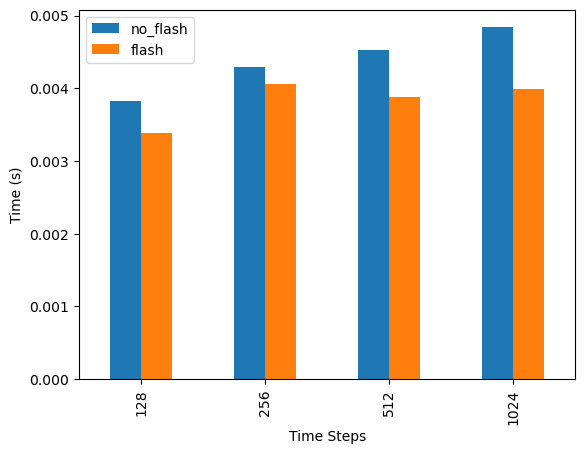

In [7]:
# T4 SRAM is smaller than newer GPUs, so less speedup gains
df["time"].plot.bar(xlabel="Time Steps", ylabel="Time (s)")

<Axes: xlabel='Time Steps', ylabel='Memory (GB)'>

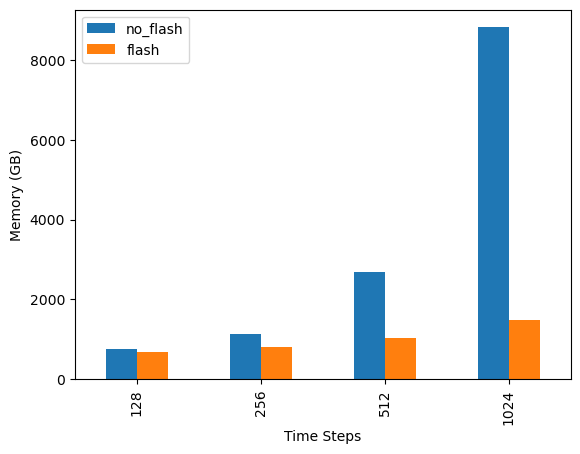

In [8]:
# Extrapolation gives you can fit 12.5K long sequence with batch size of 32 
# or a 400K long sequence with a batch size of 1 on this GPU
# But in practice, you're limited to a certain extent on the length of the 
# sequences that you can fit during training. This is a lot shorter as there's
# more computations (e.g. backward pass) during training and you need a larger
# batch size.
df["memory"].plot.bar(xlabel="Time Steps", ylabel="Memory (GB)")